In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model

# input_dir = "/home/xin/Dropbox/BrainImaging_ML/multidimensional_age_prediction/out03_age_prediction"

input_dir = "out03_age_prediction_hc2_stdz_age_reverse_notract_fa_scale_thresh.05"
output_dir = "out04_fit_brain_age_hc2_stdz_age_reverse_notract_fa_scale_thresh.05"

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# model = 'cluster_km4'
model = 'cluster_gmmEEE4'

method = 'ridge'
# method = 'svrlinear'

## disorder groups and hc test:
scatter_data = pd.read_csv(input_dir+"/out03_scatter_data_" + method + "_disorder_" + model + ".csv", 
                           sep = ",", header = 0, index_col=0)

scatter_data = scatter_data[scatter_data['group']=='HC']

cluster_idx = scatter_data['cluster'].unique()
num_cluster = len(cluster_idx)

scatter_data.set_index('cluster', inplace = True)
scatter_data.sort_index(inplace = True)

# scatter_data.index.astype('str')
scatter_data

,SUBJID,Sex,group,chronological age,brain age
cluster,,,,,
1.0,600460215379,0.0,HC,10.0,9.524500
1.0,600547831711,0.0,HC,10.0,12.430594
1.0,600561317124,1.0,HC,19.0,17.594256
1.0,600647003585,0.0,HC,18.0,16.975145
1.0,600696101074,0.0,HC,12.0,11.986204
...,...,...,...,...,...
all,609173350200,1.0,HC,12.0,12.602509
all,609706993828,1.0,HC,10.0,10.463315
all,609714765360,1.0,HC,13.0,14.022208


In [2]:
# fit brain age to do bias correction for brain age gap:

cluster_list = scatter_data.index.unique(level = 0)
regr = linear_model.LinearRegression()

for icluster in cluster_list:

    scatter_data_cluster = scatter_data.loc[icluster,:]

    y_train = scatter_data_cluster.loc[:,'brain age'].values
    X_train = np.hstack((scatter_data_cluster.loc[:,['Sex', 'chronological age']].values,
                         np.vstack((scatter_data_cluster.loc[:,'chronological age'].values**2))))

    ####### fit model with sex and interaction terms:
    X_train = np.hstack((X_train,
                         np.vstack((X_train[:,0]*X_train[:,1])), 
                         np.vstack((X_train[:,0]*X_train[:,2]))))

    # Train the model using the training set
    regr.fit(X_train, y_train)

    # Make predictions using the training set
    y_pred = regr.predict(X_train)
    
    scatter_data.at[icluster, 'brain age fit intersex'] = y_pred

scatter_data.to_csv(input_dir+'out04_healthy_controls_age_fit.csv')
scatter_data['age gap'] = scatter_data['brain age'] - scatter_data['chronological age']
scatter_data['age gap corr'] = scatter_data['brain age'] - scatter_data['brain age fit intersex']

scatter_data.reset_index(inplace = True)

scatter_data['cluster'] = scatter_data['cluster'].map({'1.0': 'cluster 1',
                                                       '2.0': 'cluster 2',
                                                       '3.0': 'cluster 3',
                                                       '4.0': 'cluster 4',
#                                                        '5.0': 'cluster 5',
                                                       'all': 'cluster all',
                                                      })

column_title = ['cluster ' + str(n) for n in range(1, num_cluster)] + ['cluster all']
scatter_data['cluster'] = pd.Categorical(scatter_data['cluster'], ordered=True,
                                         categories=column_title)

scatter_data.replace({'Sex': {0: 'F', 1: 'M'}}, inplace = True)

scatter_data.to_csv(output_dir+"/out04_scatter_data_" + method + "_cluster_" + model + "_fit_brain_age.csv")


In [3]:
scatter_data['cluster'].unique()

[cluster 1, cluster 2, cluster 3, cluster 4, cluster all]
Categories (5, object): [cluster 1 < cluster 2 < cluster 3 < cluster 4 < cluster all]

In [4]:
scatter_data

,cluster,SUBJID,Sex,group,chronological age,brain age,brain age fit intersex,age gap,age gap corr
0,cluster 1,600460215379,F,HC,10.0,9.524500,11.962211,-0.475500,-2.437711
1,cluster 1,600547831711,F,HC,10.0,12.430594,11.962211,2.430594,0.468383
2,cluster 1,600561317124,M,HC,19.0,17.594256,16.322350,-1.405744,1.271906
3,cluster 1,600647003585,F,HC,18.0,16.975145,16.526756,-1.024855,0.448389
4,cluster 1,600696101074,F,HC,12.0,11.986204,13.563419,-0.013796,-1.577215
...,...,...,...,...,...,...,...,...,...
345,cluster all,609173350200,M,HC,12.0,12.602509,13.158386,0.602509,-0.555877
346,cluster all,609706993828,M,HC,10.0,10.463315,9.558417,0.463315,0.904898
347,cluster all,609714765360,M,HC,13.0,14.022208,14.613459,1.022208,-0.591251
348,cluster all,609802779962,F,HC,16.0,18.360447,17.246511,2.360447,1.113937


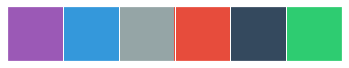

In [16]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns


def qudratic_r_squared(chro_age, brain_age):
    """
    compute the r squared of curve fit of chro_age vs. brain age.
    1. Use qudratic function to fit brain age with chronological age.
    2. Then, compute r squared of brain age and predicted brain age with qudratic fit model.
    """
    
    from scipy.optimize import curve_fit
    from sklearn.metrics import r2_score
    
    def qudratic_fun(x, a, b, c):
        return a + b*x + c*(x**2)
    
    popt, pcov = curve_fit(qudratic_fun, chro_age, brain_age)
    brain_age_pred = qudratic_fun(chro_age, popt[0], popt[1], popt[2])

    r_square = r2_score(brain_age, brain_age_pred)
    return(r_square)


text_size = 45
# colors = [sns.xkcd_rgb["windows blue"], sns.xkcd_rgb["amber"], ]
# colors = sns.color_palette("RdBu_r", 7)
# colors = [colors[5], colors[1]]

colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

sns.palplot(colors)
colors = [colors[3], colors[4]]

# this won't make difference as scatter is false in regplot?
scatter_para = {'alpha': 0.9, 's': 5, 'linewidth': 0.1}

# column_title = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster all']
# column_title = ['cluster ' + str(n) for n in range(1, num_cluster)] + ['cluster all']
column_title = ['Cluster ' + str(n) for n in range(1, num_cluster)] + ['Unidimension']


def plot_result_gender(plot_data):
    
#     plot_data = pd.melt(plot_data, id_vars = ['cluster', 'CV', 'chronological age', 'Sex'], 
#                         value_vars = ['brain age', 'age gap', 'age gap corr'])
    
    plot_data = pd.melt(plot_data, id_vars = ['cluster', 'chronological age', 'Sex'], 
                        value_vars = ['brain age', 'age gap', 'age gap corr'])

    cluster_name = plot_data['cluster'].unique()
    variable_name = plot_data['variable'].unique()
    
#     result_table_summary = result_table_summary.sort_index()
    
    # this only draws the scatter dots: 
    # we use regplot to draw regression line as they have different order of fitting function
    g = sns.lmplot(x='chronological age', y='value', hue = 'Sex', col = 'cluster', row = 'variable', \
                   row_order = ['brain age','age gap', 'age gap corr'], palette = colors, \
                   data = plot_data, fit_reg=False, 
                   facet_kws = {'sharex':True, 'sharey':False}, \
                   markers=["o", "v"],
                   scatter_kws={'alpha':0.7, 's':400}, x_jitter = .2,\
                   height=10.27, aspect=10.27/10.27, legend = False)
    
    g.axes[0,0].set_xlim(6.5, 23.5)
    
    # uncomment if legend = True:
#     plt.setp(g._legend.get_title(), fontsize=40)
    
#     for lh in g._legend.legendHandles: 
#         lh.set_alpha(1)
#         lh._sizes = [450] 
    
    ## draws the regression line for each row:
    sub_plot = 0
    lw = 7.5
    for i_cluster in cluster_name:

        i_plot_data = plot_data.loc[(plot_data['cluster']==i_cluster) & (plot_data['variable']=='brain age'),:]
        
        chro_age_m = i_plot_data.loc[(i_plot_data['Sex']=='M','chronological age')].values
        chro_age_f = i_plot_data.loc[(i_plot_data['Sex']=='F','chronological age')].values
        
        brain_age_m = i_plot_data.loc[(i_plot_data['Sex']=='M','value')].values
        brain_age_f = i_plot_data.loc[(i_plot_data['Sex']=='F','value')].values
        
        # chronological age vs age gap:
        label2 = "Male: $R^2$ = %.3f, MAE = %.3f" % \
        (qudratic_r_squared(chro_age_m, brain_age_m),\
         np.mean(np.abs(chro_age_m - brain_age_m)))
        
        label1 = "Female: $R^2$ = %.3f, MAE = %.3f" % \
        (qudratic_r_squared(chro_age_f, brain_age_f),\
         np.mean(np.abs(chro_age_f - brain_age_f)))
        
        sns.regplot(x='chronological age', y='value', scatter_kws = scatter_para, color = colors[0], \
                    data = i_plot_data.loc[(i_plot_data['Sex']=='F'),:], scatter=False, \
                    line_kws={'alpha':0.9, 'linewidth':lw, 'label':'Female'},
                    ax=g.axes[0, sub_plot], order = 2)
        
        sns.regplot(x='chronological age', y='value', scatter_kws = scatter_para, color = colors[1],\
                    data = i_plot_data.loc[(i_plot_data['Sex']=='M'),:], scatter=False, \
                    line_kws={'alpha':0.9, 'linewidth':lw, 'label':'Male', 'lineStyle':'dashed'},
                    ax=g.axes[0, sub_plot], order = 2)

        g.axes[0, sub_plot].text(6.5, 20, label1, fontsize = text_size-5)
        g.axes[0, sub_plot].text(6.5, 21, label2, fontsize = text_size-5)
        g.axes[0, sub_plot].set_ylim(5.5, 22.5)
        
        g.axes[0, sub_plot].set_title(column_title[sub_plot])
        g.axes[0, sub_plot].set_xlabel('')
        
        if sub_plot == 0:
            g.axes[0, sub_plot].set_ylabel('brain age')
        else:
            g.axes[0, sub_plot].set_ylabel('')
            g.axes[0, sub_plot].set(yticklabels=[])
        
        
        sub_plot = sub_plot + 1
    
    ## create custom legend for regplot:
    female_line = mlines.Line2D([], [], color=colors[0], marker='o',linewidth=lw,
                      markersize=25, label='Female')
    male_line = mlines.Line2D([], [], color=colors[1], marker='v', linewidth=lw, lineStyle = 'dashed',
                              markersize=25, label='Male')

    g.axes[0, -1].legend(handles=[female_line, male_line], loc = 'lower right',frameon=False)
    plt.setp(g.axes[0, -1].get_legend().get_texts(), fontsize='35')
    ## end legend.
    
    text_x = 13.5
    text_y1 = 5
    text_y2 = 6
    
    sub_plot = 0
    for i_cluster in cluster_name:
        
        i_plot_data = plot_data.loc[(plot_data['cluster']==i_cluster) & (plot_data['variable']=='age gap'),:]
        # chronological age vs brain age:
        chro_age_m = i_plot_data.loc[i_plot_data['Sex']=='M', 'chronological age'].values
        chro_age_f = i_plot_data.loc[i_plot_data['Sex']=='F', 'chronological age'].values
        
        age_gap_m = i_plot_data.loc[i_plot_data['Sex']=='M', 'value'].values
        age_gap_f = i_plot_data.loc[i_plot_data['Sex']=='F', 'value'].values
        
        corr_m = np.corrcoef(chro_age_m, age_gap_m)[0,1]
        corr_f = np.corrcoef(chro_age_f, age_gap_f)[0,1]
        # chronological age vs brain age:
        label2 = "Male: r = %.3f" % corr_m
        label1 = "Female: r = %.3f" % corr_f
        
        sns.regplot(x='chronological age', y='value', scatter_kws = scatter_para, color = colors[0], \
                    data = i_plot_data.loc[i_plot_data['Sex']=='F',:], scatter=False, 
                    line_kws={'alpha':0.9, 'linewidth':lw, 'label':'Female'},
                    ax=g.axes[1, sub_plot], order = 1)
        
        sns.regplot(x='chronological age', y='value', scatter_kws = scatter_para, color = colors[1],\
                    data = i_plot_data.loc[i_plot_data['Sex']=='M',:], scatter=False, 
                    line_kws={'alpha':0.9, 'linewidth':lw, 'label':'Male', 'lineStyle':'dashed'},
                    ax=g.axes[1, sub_plot], order = 1)

        #text_y = plot_data['brain age'].max()+.2
        g.axes[1, sub_plot].text(text_x, text_y1, label1, fontsize = text_size)
        g.axes[1, sub_plot].text(text_x, text_y2, label2, fontsize = text_size)
        
        g.axes[1, sub_plot].set_title('')
        g.axes[1, sub_plot].set_xlabel('')
        g.axes[1, sub_plot].set_ylim(-6.5, 7)
        
        if sub_plot == 0:
            g.axes[1, sub_plot].set_ylabel('BAG')
        else:
            g.axes[1, sub_plot].set_ylabel('')
            g.axes[1, sub_plot].set(yticklabels=[])
        sub_plot = sub_plot + 1
        
    sub_plot = 0
    for i_cluster in cluster_name:
        
        i_plot_data = plot_data.loc[(plot_data['cluster']==i_cluster) & (plot_data['variable']=='age gap corr'),:]
        # chronological age vs brain age:
        chro_age_m = i_plot_data.loc[i_plot_data['Sex']=='M', 'chronological age'].values
        chro_age_f = i_plot_data.loc[i_plot_data['Sex']=='F', 'chronological age'].values
        
        age_gap_m = i_plot_data.loc[i_plot_data['Sex']=='M', 'value'].values
        age_gap_f = i_plot_data.loc[i_plot_data['Sex']=='F', 'value'].values
        
        corr_m = np.corrcoef(chro_age_m, age_gap_m)[0,1]
        corr_f = np.corrcoef(chro_age_f, age_gap_f)[0,1]
        # chronological age vs brain age:
        label2 = "Male: r = %.3f" % corr_m
        label1 = "Female: r = %.3f" % corr_f
        
        sns.regplot(x='chronological age', y='value', scatter_kws = scatter_para, color = colors[0], \
                    data = i_plot_data.loc[i_plot_data['Sex']=='F',:], scatter=False, 
                    line_kws={'alpha':0.9, 'linewidth':lw, 'label':'Female'},
                    ax=g.axes[2, sub_plot], order = 1)
        sns.regplot(x='chronological age', y='value', scatter_kws = scatter_para, color = colors[1],\
                    data = i_plot_data.loc[i_plot_data['Sex']=='M',:], scatter=False, 
                    line_kws={'alpha':0.9, 'linewidth':lw, 'label':'Male', 'lineStyle':'dashed'},
                    ax=g.axes[2, sub_plot], order = 1)

        #text_y = plot_data['brain age'].max()+.2
        g.axes[2, sub_plot].text(text_x, text_y1, label1, fontsize = text_size)
        g.axes[2, sub_plot].text(text_x, text_y2, label2, fontsize = text_size)
        
        g.axes[2, sub_plot].set_title('')
        g.axes[2, sub_plot].set_ylim(-6.5, 7)
        
        if sub_plot == 0:
            g.axes[2, sub_plot].set_ylabel('corrected BAG')
        else:
            g.axes[2, sub_plot].set_ylabel('')
            g.axes[2, sub_plot].set(yticklabels=[])
        sub_plot = sub_plot + 1

In [6]:
scatter_data['cluster'].unique()

[cluster 1, cluster 2, cluster 3, cluster 4, cluster all]
Categories (5, object): [cluster 1 < cluster 2 < cluster 3 < cluster 4 < cluster all]

C:\Users\Xin\Anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


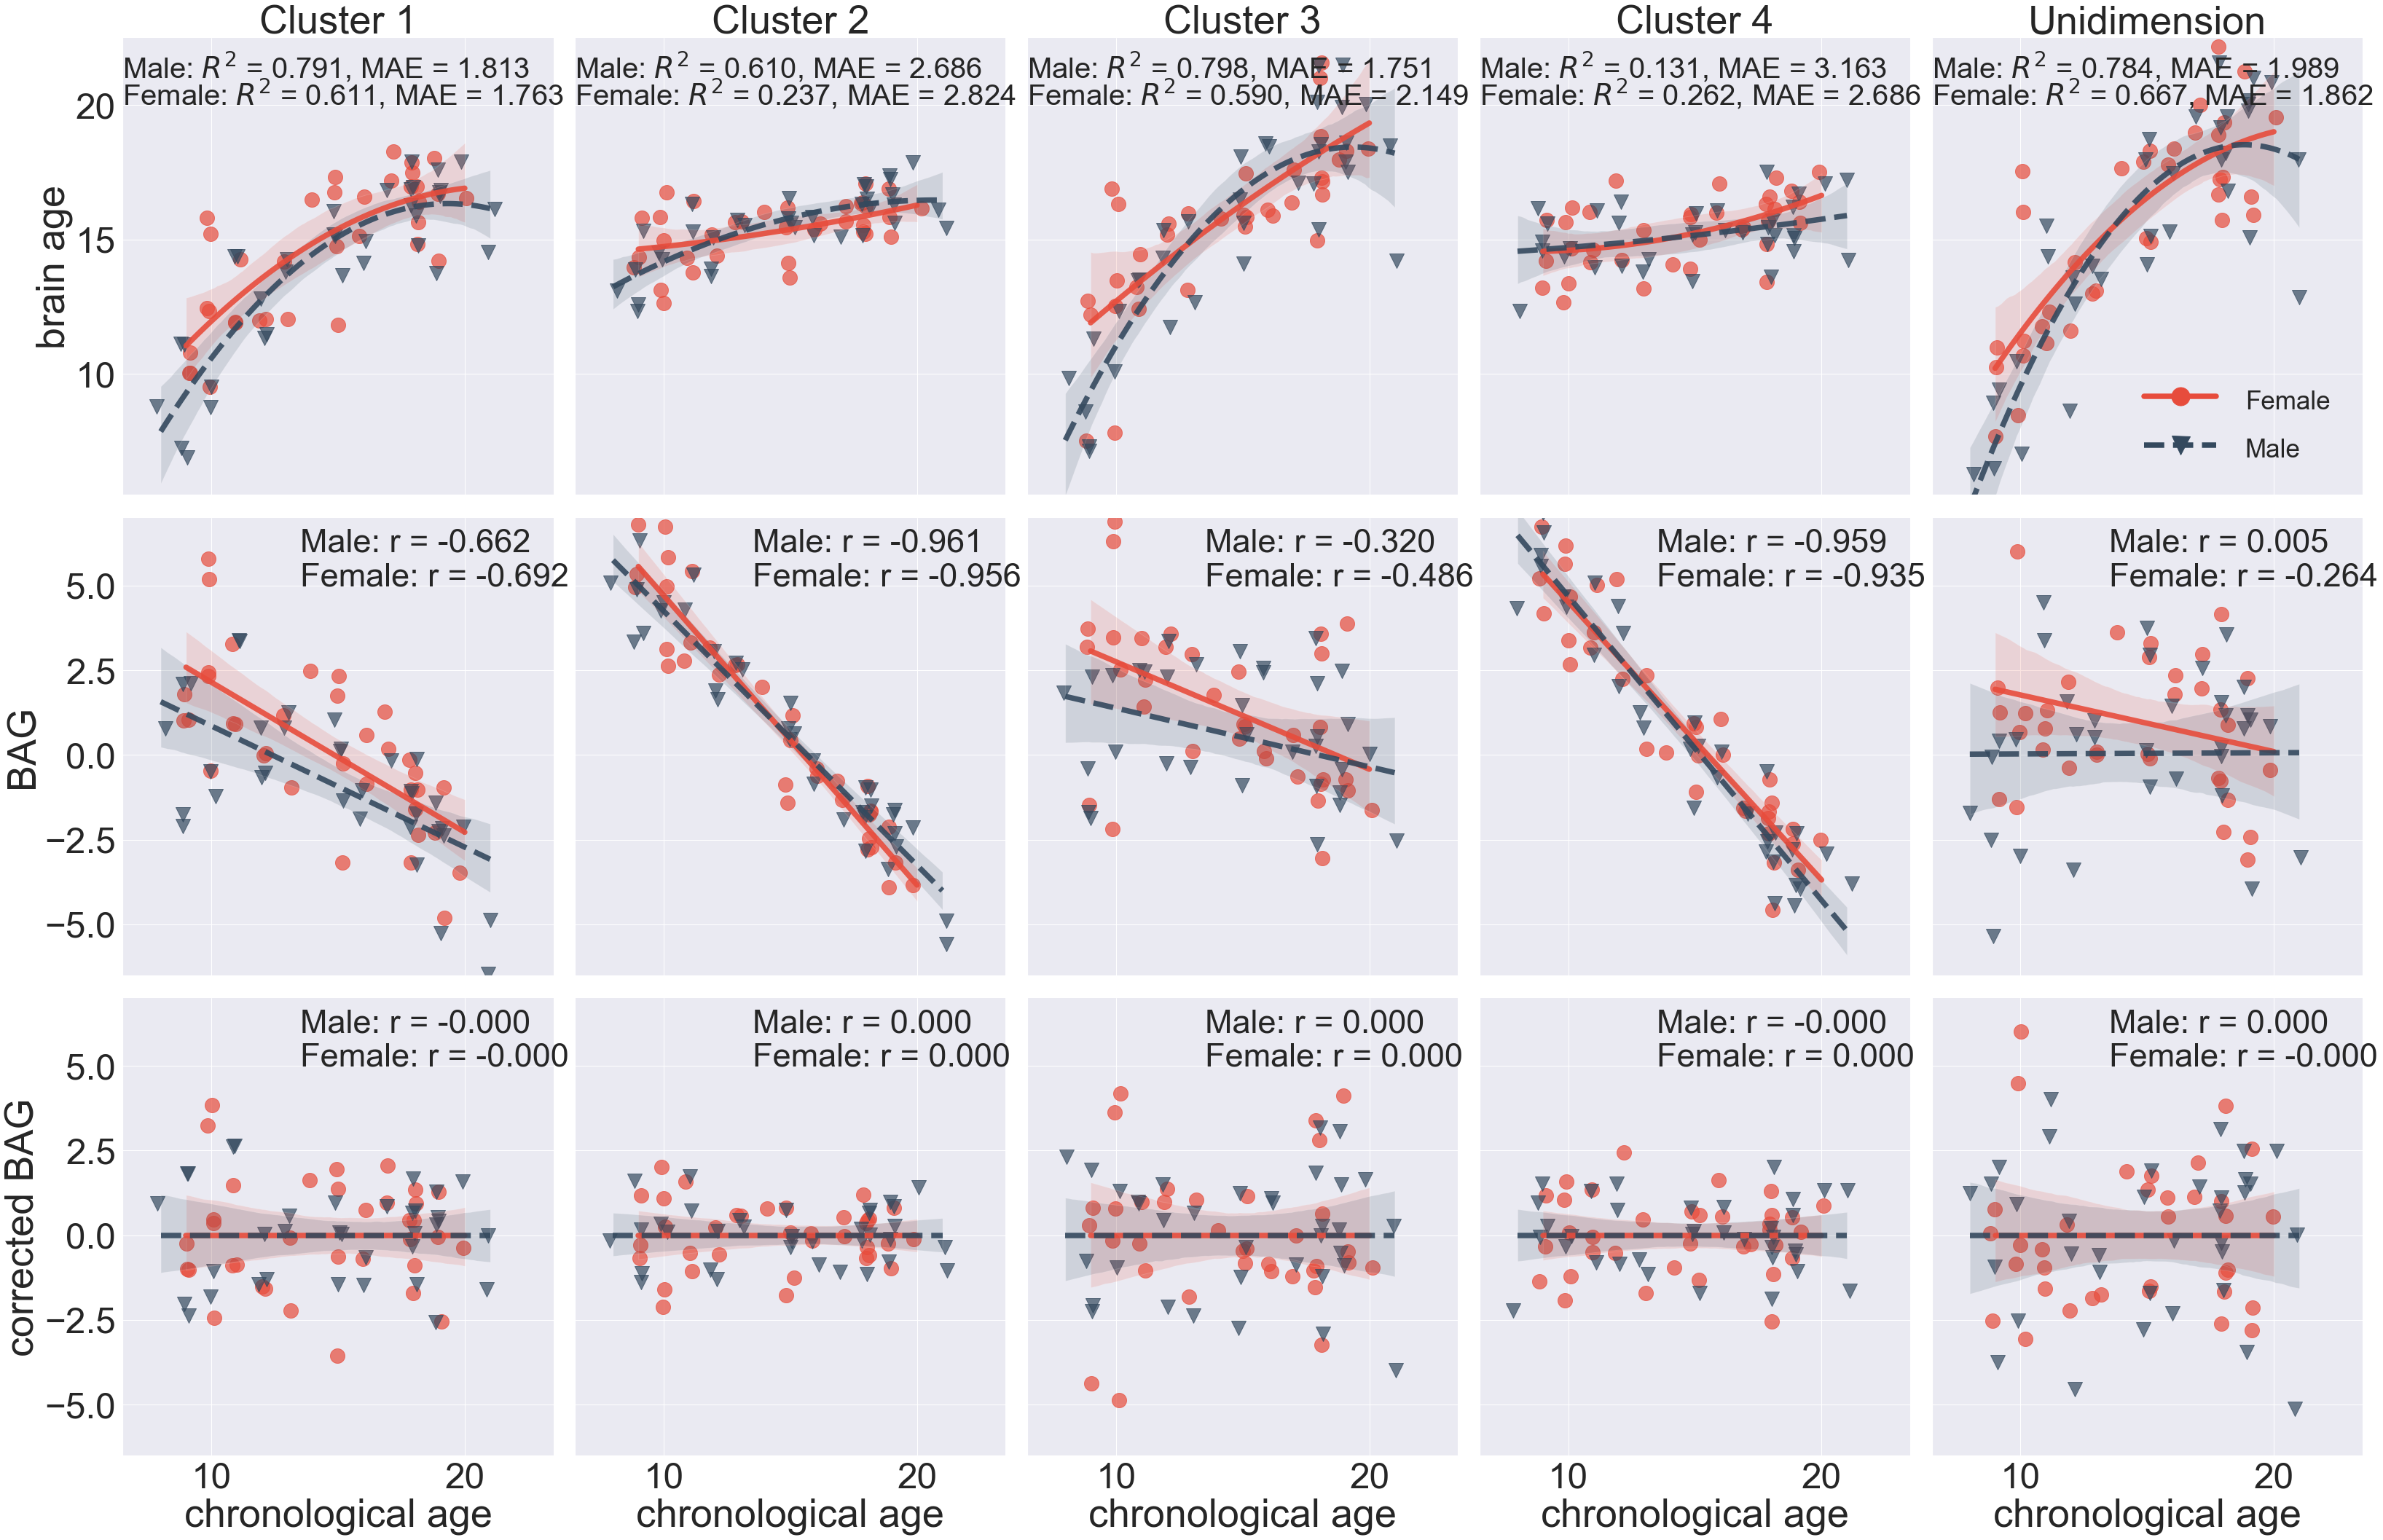

In [17]:
sns.set(rc={'figure.figsize':(9, 9)}, font_scale = 4.5)
plot_result_gender(scatter_data)

plt.subplots_adjust(hspace=0.05, wspace=0.05)
plt.savefig(output_dir+'/figure4_scatter_merge_gender_intersex_' + method + '_' + model + '.png', dpi=600)